In [6]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Set environment variable to point to your kaggle.json location
os.environ['KAGGLE_CONFIG_DIR'] = r'C:\Users\saket\.kaggle'

# Authenticate with Kaggle
api = KaggleApi()
api.authenticate()

# Download and unzip the dataset to 'maternal_data' folder
api.dataset_download_files('csafrit2/maternal-health-risk-data', path='maternal_data', unzip=True)

print("✅ Dataset downloaded to: maternal_data/")


Dataset URL: https://www.kaggle.com/datasets/csafrit2/maternal-health-risk-data
✅ Dataset downloaded to: maternal_data/


📊 Dataset loaded: 1014 rows × 7 columns

📋 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
None

🔍 Missing Values:
Series([], dtype: int64)

🔍 Duplicate Rows:
562

📈 Skewness Check:
BS             1.868203
BodyTemp       1.750988
Age            0.783063
DiastolicBP   -0.048441
SystolicBP    -0.251189
HeartRate     -1.043525
dtype: float64

📌 Recommendation:
⚠️ BS is highly skewed (skew=1.87). Suggest: Apply log or sqrt transform.
⚠️ BodyTemp is highly skewed (skew=1.75). Suggest: Appl

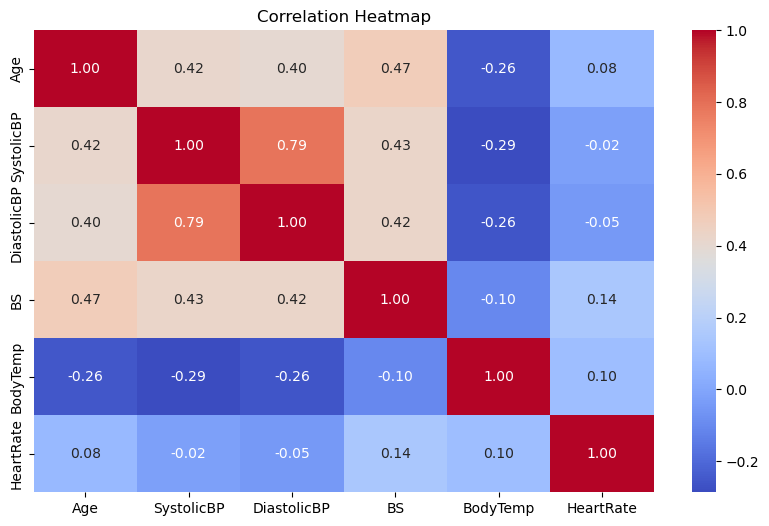

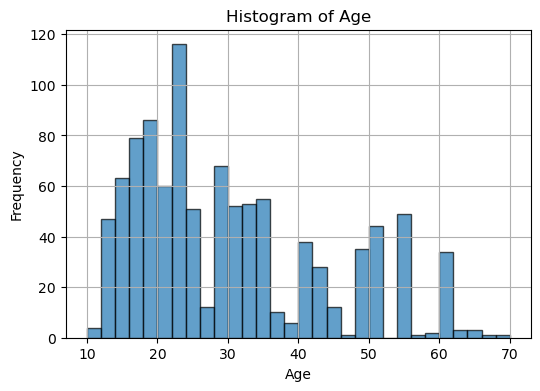

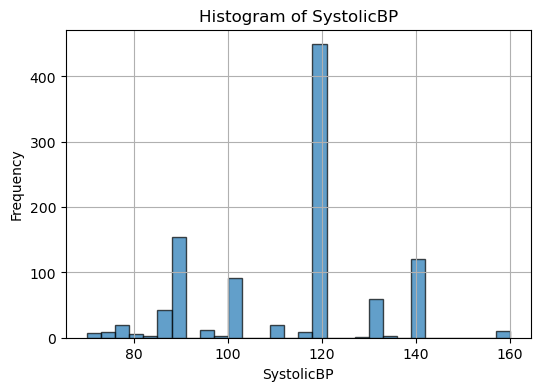

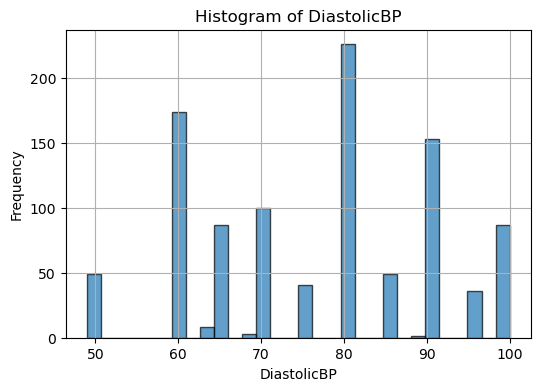

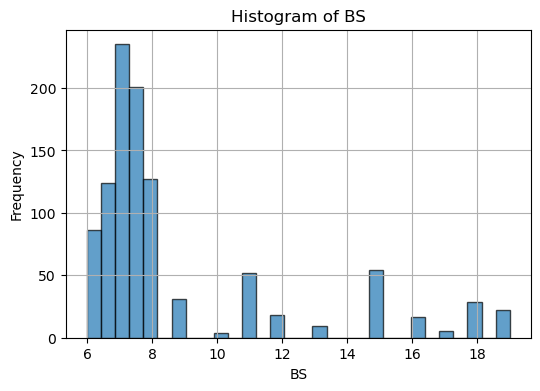

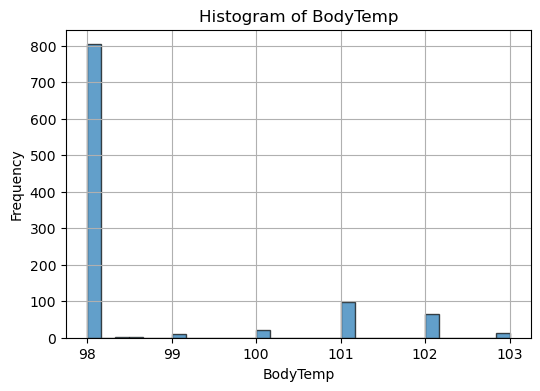

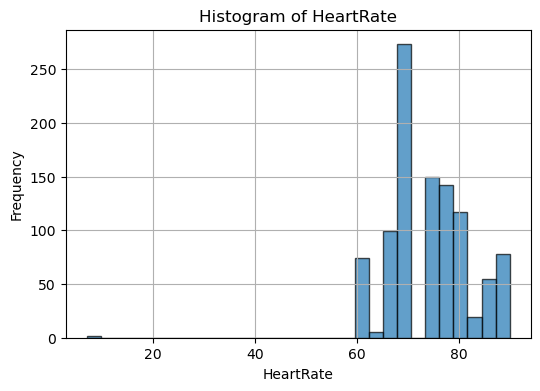

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ====== 1. Load Data ======
df = pd.read_csv(r"C:\Users\saket\Downloads\maternal_care-main\maternal_care-main\Maternal Health Risk Data Set.csv") 
print(f"📊 Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")

# ====== 2. Basic Info ======
print("\n📋 Basic Info:")
print(df.info())

# ====== 3. Missing Values & Duplicate Rows Check ======
print("\n🔍 Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])

print("\n🔍 Duplicate Rows:")
duplicate = df.duplicated().sum()
print(duplicate)

# ====== 4. Skewness Check ======
print("\n📈 Skewness Check:")
skewed_features = df.select_dtypes(include=['number']).apply(lambda x: x.skew()).sort_values(ascending=False)
print(skewed_features)

print("\n📌 Recommendation:")
for col, skew in skewed_features.items():
    if abs(skew) > 1:
        print(f"⚠️ {col} is highly skewed (skew={skew:.2f}). Suggest: Apply log or sqrt transform.")
    elif abs(skew) > 0.5:
        print(f"ℹ️ {col} is moderately skewed (skew={skew:.2f}). Transform optional.")
    else:
        print(f"✅ {col} is fairly symmetric (skew={skew:.2f}). No action needed.")

# ====== 5. Outlier Detection (IQR Method) ======
print("\n📦 Outlier Check (IQR Method):")
for col in df.select_dtypes(include=['number']):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_count = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    if outlier_count > 0:
        print(f"⚠️ {col}: {outlier_count} outliers detected.")
    else:
        print(f"✅ {col}: No significant outliers.")

# ====== 6. Correlation Analysis ======
print("\n🔗 Correlation Matrix (Top correlated pairs):")
correlation = df.corr(numeric_only=True)
cor_matrix = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()
top_corr = cor_matrix[(cor_matrix < 1) & (cor_matrix > 0.7)]
print(top_corr)

print("\n📌 Recommendation:")
for (f1, f2), corr_val in top_corr.items():
    print(f"⚠️ {f1} & {f2} have high correlation ({corr_val:.2f}). Suggest: Keep only one or apply dimensionality reduction (e.g., PCA).")

# ====== 7. Heatmap ======
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# ====== 8. Histogram ======
df_numeric = df.select_dtypes(include=["number"])  # Pilih hanya kolom numerik
for col in df_numeric.columns:
    plt.figure(figsize=(6, 4))
    plt.hist(df_numeric[col], bins=30, edgecolor="black", alpha=0.7)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [8]:
df.head(10)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.00,98.0,86,high risk
1,35,140,90,13.00,98.0,70,high risk
2,29,90,70,8.00,100.0,80,high risk
3,30,140,85,7.00,98.0,70,high risk
4,35,120,60,6.10,98.0,76,low risk
5,23,140,80,7.01,98.0,70,high risk
6,23,130,70,7.01,98.0,78,mid risk
7,35,85,60,11.00,102.0,86,high risk
8,32,120,90,6.90,98.0,70,mid risk
9,42,130,80,18.00,98.0,70,high risk


In [9]:
#print(f"Before: {df.shape}")
#df.drop_duplicates(inplace=True)
#print(f"After: {df.shape}")

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Set Target
X = df.drop(columns=['RiskLevel'])
y = df['RiskLevel']

# Deteksi kolom kategorikal dan numerik dari X
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

# Pipeline untuk numerik
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler()) # bisa diganti untuk MinMaxScaler
])

# Pipeline untuk Kategorikal + Handling Missing Values
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore')) # bisa diganti untuk LabelEncoder
])

# Gabung dengan ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

# Full Pipeline Model
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestClassifier()) # model bisa diganti regresi atau yg lain dan model yang digunakan
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit pipeline
pipeline.fit(X_train, y_train)

# Prediksi
y_pred = pipeline.predict(X_test)

# Evaluasi model
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

   high risk       0.85      0.95      0.90        55
    low risk       0.86      0.79      0.83        81
    mid risk       0.74      0.75      0.74        67

    accuracy                           0.82       203
   macro avg       0.82      0.83      0.82       203
weighted avg       0.82      0.82      0.82       203

